<a href="https://colab.research.google.com/github/big-muzzy/Autoencoders/blob/master/Conditional_Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Пример Вариационного автокодировщика. С условием.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate, Reshape, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Layer
from tensorflow.keras import utils
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения
import time



Функция для отрисовки картинок

In [ ]:
def plotImages(startIndex, imgs): # создадим функцию для вывода изображений как картинок
  n = 10  # количество картинок, которые хотим показать
  plt.figure(figsize=(20, 2)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = i + startIndex # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки
      ax = plt.subplot(1, n, i + 1) # выведем область рисования Axes
      plt.imshow(imgs[index].reshape(28, 28)) # отрисуем правильные картинки в размере 28*28
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

функция для отрисовки графика обучения нейросети

In [ ]:
def plotGraph(acc, valacc):
  plt.plot(acc, label='Обучающий набор')
  plt.plot(valacc, label='Проверочный набор')
  plt.xlabel('Эпохи обучения')
  plt.ylabel('Точность')
  plt.legend()
  plt.show()

Загружаем данные - MNIST. Набор рукописных цифр.

In [ ]:
(xtrain_num_org, ytrain_num_org), (xtest_num_org, ytest_num_org) = mnist.load_data()
xtrain_num = xtrain_num_org.astype(float) / 255. 
xtrain_num = xtrain_num.reshape(60000, 28, 28, 1)
xtest_num = xtest_num_org.astype(float) / 255. 
xtest_num = xtest_num.reshape(10000, 28, 28, 1)
ytrain_num = utils.to_categorical(ytrain_num_org, 10, dtype=float)
ytest_num = utils.to_categorical(ytest_num_org, 10, dtype=float)

11493376/11490434 [==============================] - 0s 0us/step


Специальный слой для смещения точки в скрытом пространстве. Так мы научим декодер работать не с одной точкой, а с целыми облаками, и в итоге скрытое пространство будет заполнено плотнее

In [ ]:
class Sampling(Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

Модель вариационного автокодировщика с условием. 

In [ ]:
def createJustDenseModel(original_dim, z_dim = 128, kld_weight = 1):
  output_dim = original_dim[0] * original_dim[1]
  model = {}

  input_img = Input(shape=original_dim, name='encoder_input')
  input_label = Input(shape=(10,), dtype=float, name='e_label_input')
  x = Flatten()(input_img)
  x = concatenate([x, input_label])
  x = Dense(1024, activation='relu', name='e_Dense_1')(x)
  x = Dense(1024, activation='relu', name='e_Dense_2')(x)
  z_mean = Dense(z_dim, activation='relu', name='z_mean')(x)
  z_log_var = Dense(z_dim, activation='relu', name='z_log_var')(x)
  output_z = Sampling(name='Sampling')((z_mean, z_log_var))

  input_z = Input(shape=(z_dim,), name='latent_input')
  input_z_label = Input(shape=(10,), dtype=float, name='d_label_input')
  d = concatenate([input_z, input_z_label])
  d = Dense(1024, activation='relu', name='d_dense_1')(d)
  d = Dense(1024, activation='relu', name='d_dense_2')(d)
  d = Dense(output_dim, activation='sigmoid', name='d_dense_out')(d)
  output_img = Reshape(target_shape=original_dim, name='d_Reshape')(d)

  #Собираем модели
  model['encoder'] = Model([input_img, input_label], output_z, name='encoder')
  model['z_mean'] = Model([input_img, input_label], z_mean, name='z_mean')
  model['decoder'] = Model([input_z, input_z_label], output_img, name='decoder')
  model['cvae'] = Model([input_img, input_label, input_z_label], 
                       model['decoder']([model['encoder']([input_img, input_label]), input_z_label]), name='cvae')
  model['style_t'] = Model([input_img, input_label, input_z_label], 
                      model['decoder']([model['z_mean']([input_img, input_label]), input_z_label]), name='style_t')

  kl_loss = - 0.5 * K.mean(z_log_var - K.square(z_mean) - K.exp(z_log_var) + 1) * kld_weight
  model['cvae'].add_loss(kl_loss)
  return model

...и функция для тестирования моделей

In [ ]:
def testModel(xtrain, ytrain, xtest, ytest, zdim = 128, kld_weight = 1, createModel = createJustDenseModel, epochs=32):
  start = time.time()
  models = createModel(xtrain[0].shape[1:], z_dim=zdim, kld_weight=kld_weight)
  models['cvae'].compile(optimizer='adam', loss='mse')
  history = models['cvae'].fit(xtrain, ytrain, batch_size=256, epochs=epochs, verbose=0, validation_data=(xtest, ytest))
  print([round(val, 4) for val in history.history['val_loss']])
  plotGraph(history.history['loss'], history.history['val_loss'])
  predict = models['cvae'].predict(xtest)
  plotImages(0, xtest[0])
  plotImages(0, predict)

  print('std:')
  z_mean_pred = models['z_mean'].predict(xtest)
  std = z_mean_pred.std(axis=0)
  print(std[:50])
  print(std.shape)

  print('time:', time.time() - start, 'sec.')

  return models


Обучение модели.

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: e_label_input_4:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: e_label_input_4:0
[0.051, 0.045, 0.0431, 0.0418, 0.0409, 0.0404, 0.04, 0.0397, 0.0393, 0.0391, 0.0387, 0.0385, 0.0385, 0.0383, 0.0382, 0.038, 0.0379, 0.0379, 0.0377, 0.0376, 0.0375, 0.0376, 0.0375, 0.0374, 0.0374, 0.0372, 0.0374, 0.0372, 0.0373, 0.0372, 0.0371, 0.037, 0.037, 0.0371, 0.0372, 0.037, 0.037, 0.0367, 0.037, 0.0369, 0.0368, 0.0369, 0.0368, 0.0371, 0.0368, 0.0368, 0.0368, 0.0367, 0.0368, 0.0367, 0.0366, 0.0368, 0.0367, 0.0367, 0.0367, 0.0366, 0.0366, 0.0366, 0.0367, 0.0366, 0.0366, 0.0367, 0.0368, 0.0367]


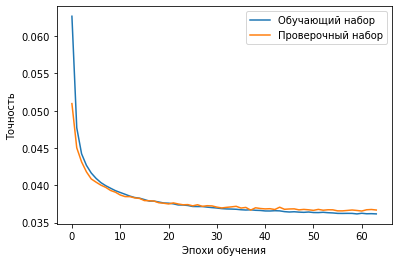

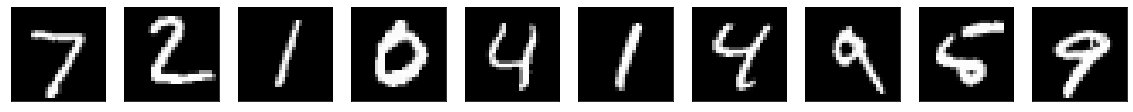

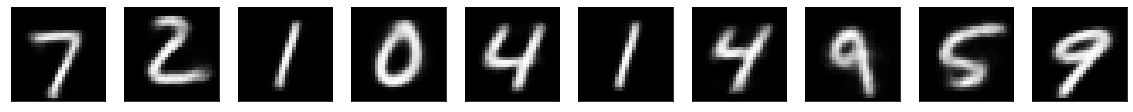

std:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.8141182  0.         0.
 0.         0.         0.         0.78687555 0.         0.
 0.         0.         0.         0.00275316 0.75558734 0.
 0.         0.         0.         0.74503076 0.         0.
 0.7609849  0.         0.         0.         0.6910741  0.
 0.         0.         0.         0.         0.         0.74712354
 0.         0.         0.         0.6688769  0.9197528  0.81490356
 0.         0.        ]
(128,)
time: 160.91775393486023 sec.


In [ ]:
models = testModel([xtrain_num, ytrain_num, ytrain_num], xtrain_num, [xtest_num, ytest_num, ytest_num], xtest_num, kld_weight=0.1, zdim=128, createModel=createJustDenseModel, epochs=64)


Результаты:

In [ ]:
Lens = []
for i in range(10):
  Lens.append(sum(ytest_num_org == i))
print(Lens)

xtest_n_sorted = np.empty(((sum(Lens),) + xtest_num.shape[1:]), dtype=float)
curr = 0
for i in range(10):
  print(curr, Lens[i])
  xtest_n_sorted[curr:curr + Lens[i]] = xtest_num[ytest_num_org == i][:Lens[i]]
  curr += Lens[i]

print(xtest_n_sorted.shape)


[980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]
0 980
980 1135
2115 1032
3147 1010
4157 982
5139 892
6031 958
6989 1028
8017 974
8991 1009
(10000, 28, 28, 1)


(10, 28, 28, 1)


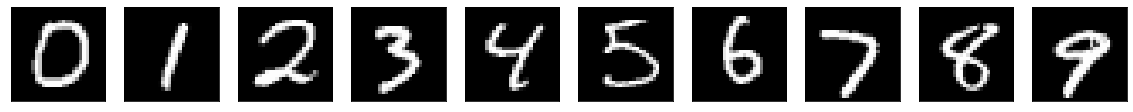

In [ ]:
img_org = []
st_num = 0
offset = 1
for i in Lens:
  img_org.append(xtest_n_sorted[st_num + offset])
  st_num += i



img_org = np.array(img_org)
print(img_org.shape)
plotImages2(0, img_org)


Перенос стиля на разные цифры. 

Входные данные
(10, 28, 28, 1)


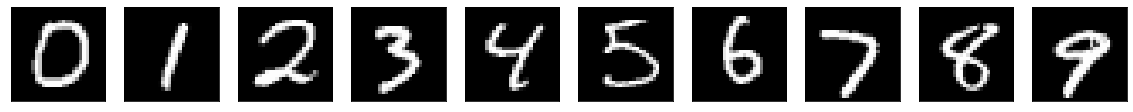

zmean shape: (10, 128)
Перенос стиля цифр


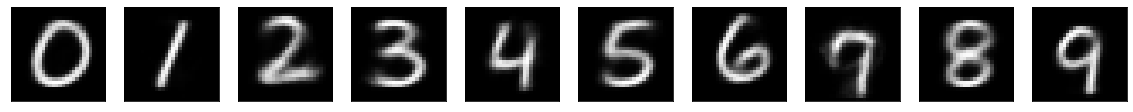

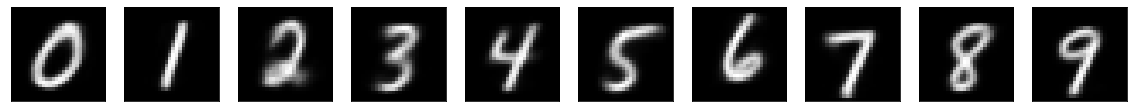

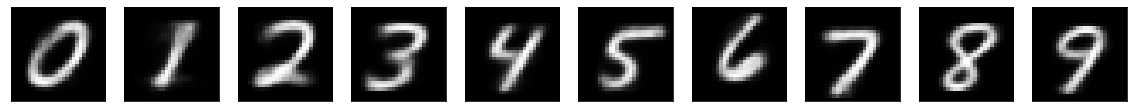

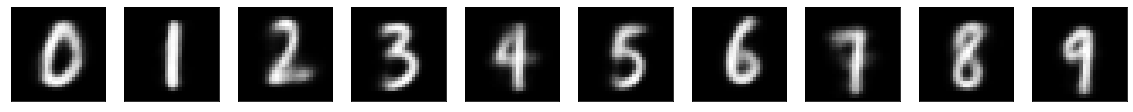

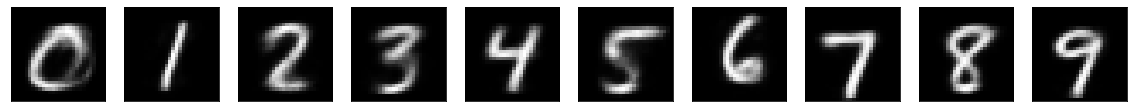

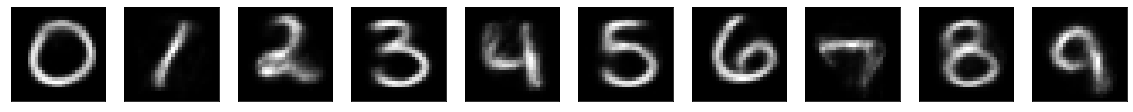

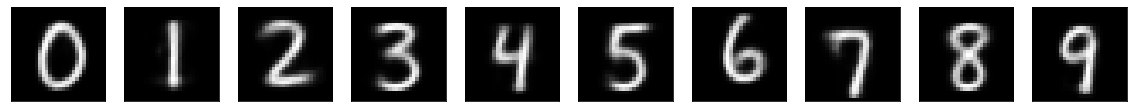

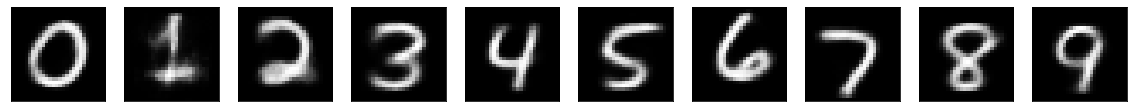

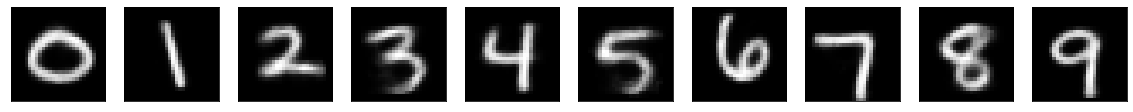

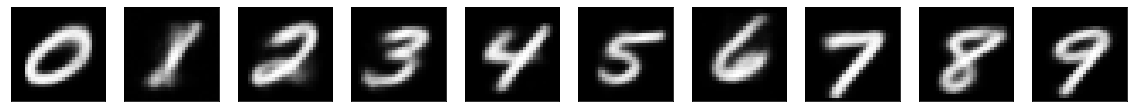

In [ ]:
print('Входные данные')
print(img_org.shape)
plotImages(0, img_org)

img_labels = []
for i in range(10):
  img_labels.append(utils.to_categorical(i, 10, dtype=float))
img_labels = np.array(img_labels)

img_z_mean = models['z_mean'].predict([img_org, img_labels])
print('zmean shape:', img_z_mean.shape)


print('Перенос стиля цифр')
for n in range(10):
  src = img_org[n]
  img_list = []
  in_style_labels = []
  for i in range(10):
    img_list.append(src)
    in_style_labels.append(utils.to_categorical(n, 10, dtype=float))
  img_list = np.array(img_list)
  in_style_labels = np.array(in_style_labels)
  decoded = models['style_t'].predict([img_list, in_style_labels, img_labels])
  plotImages2(0, decoded)
